# ***Transfer Learning using PreTrained Models***

The pre-trained models are trained on very large scale image classification problems. The convolutional layers act as feature extractor and the fully connected layers act as Classifiers.

1.   Transfer Learning - We can either use the convolutional layers merely as a feature extractor.

2.   Fine Tuning - Tweak the already trained convolutional layers to suit our problem at hand.



## ***Download and Prepare Data***

### ***Use of imagenetscraper/Clone Git***

In [1]:
pip install imagenetscraper

     |████████████████████████████████| 5.6MB 5.6MB/s 
     |████████████████████████████████| 256kB 35.4MB/s 
  Created wheel for frogress: filename=frogress-0.9.1-cp37-none-any.whl size=14461 sha256=dc190cbfc1d6a97762c9f6ed682c35b68f12e6e587ec3168d5206a10a67f2e85
  Stored in directory: /root/.cache/pip/wheels/2e/16/a3/694d34aba3db2000b4497bb0ce3f60f7c593b19c7aa465dad2
Successfully built frogress


In [2]:
!git clone https://github.com/spmallick/learnopencv.git

Cloning into 'learnopencv'...
remote: Enumerating objects: 8845, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 8845 (delta 7), reused 11 (delta 2), pack-reused 8819
Receiving objects: 100% (8845/8845), 937.66 MiB | 23.82 MiB/s, done.
Resolving deltas: 100% (2510/2510), done.
Checking out files: 100% (4001/4001), done.


## ***Load PreTrained Model - VGG16 NET***

In [3]:
from tensorflow.keras.applications import vgg16

vgg_conv = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

58892288/58889256 [==============================] - 1s 0us/step


### ***Extract Features***

In [4]:
train_dir = '/content/learnopencv/Keras-Fine-Tuning/clean-dataset/train'
validation_dir = '/content/learnopencv/Keras-Fine-Tuning/clean-dataset/validation'

# divide images for train and test into 80:20 ratio
nTrain = 600
nVal = 150

### ***Train Feature Generator***

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt



from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 20

train_features = np.zeros(shape=(nTrain, 7,7,512))
train_labels = np.zeros(shape=(nTrain, 3))

train_generator = datagen.flow_from_directory(train_dir,
                                              target_size=(224,224),
                                              batch_size=batch_size, 
                                              class_mode='categorical',
                                              shuffle=True)


Found 600 images belonging to 3 classes.


In [7]:
#  we use model.predict() function to pass the image through the network which gives us a 7 x 7 x 512 dimensional Tensor

for i, (input_batch, label_batch) in enumerate(train_generator):
  if i*batch_size >= nTrain:
    break
  
  # pass image through network
  features_batch = vgg_conv.predict(input_batch)
  train_features[i*batch_size: (i+1)*batch_size] = features_batch
  train_labels[i*batch_size: (i+1)*batch_size] = label_batch

# reshape train_features into vector 

train_features_vec = np.reshape(train_features, newshape=(nTrain, 7*7*512))
print('Train Features Shape: {}'.format(train_features_vec.shape))

Train Features Shape: (600, 25088)


### ***Validation Feature Generator***

In [8]:
val_features = np.zeros(shape=(nVal, 7,7,512))
val_labels = np.zeros(shape=(nVal, 3))

batch_size=10

val_generator = datagen.flow_from_directory(validation_dir,
                                            target_size=(224,224),
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

for i, (input_batch, label_batch) in enumerate(val_generator):
  if i*batch_size >= nVal:
    break
  
  # pass val_images through network to capture features
  features_batch = vgg_conv.predict(input_batch)
  val_features[i*batch_size: (i+1)*batch_size] = features_batch
  val_labels[i*batch_size: (i+1)*batch_size] = label_batch

# reshape val_features into vector 
val_features_vec = np.reshape(val_features, newshape=(nVal, 7*7*512))
print('Validation Features Shape: {}'.format(val_features_vec.shape))

Found 150 images belonging to 3 classes.
Validation Features Shape: (150, 25088)


### ***Create and Train Model***

In [9]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential, optimizers

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=(7*7*512)))
model.add(Dropout(rate=0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer = optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

# train model
history = model.fit(train_features_vec,
                    train_labels,
                    epochs=20, 
                    batch_size=batch_size,
                    validation_data=(val_features_vec, val_labels))



Epoch 1/20
60/60 [==============================] - 2s 17ms/step - loss: 2.0589 - acc: 0.4929 - val_loss: 0.7333 - val_acc: 0.6600
Epoch 2/20
60/60 [==============================] - 1s 14ms/step - loss: 0.4266 - acc: 0.8370 - val_loss: 0.4394 - val_acc: 0.8600
Epoch 3/20
60/60 [==============================] - 1s 14ms/step - loss: 0.3127 - acc: 0.8943 - val_loss: 0.3293 - val_acc: 0.8933
Epoch 4/20
60/60 [==============================] - 1s 14ms/step - loss: 0.0973 - acc: 0.9708 - val_loss: 0.5900 - val_acc: 0.8333
Epoch 5/20
60/60 [==============================] - 1s 14ms/step - loss: 0.1206 - acc: 0.9650 - val_loss: 0.4117 - val_acc: 0.8867
Epoch 6/20
60/60 [==============================] - 1s 14ms/step - loss: 0.0816 - acc: 0.9776 - val_loss: 0.3803 - val_acc: 0.9067
Epoch 7/20
60/60 [==============================] - 1s 14ms/step - loss: 0.0477 - acc: 0.9803 - val_loss: 0.4673 - val_acc: 0.8867
Epoch 8/20
60/60 [==============================] - 1s 14ms/step - loss: 0.0474 - a

### ***Plot Performance***

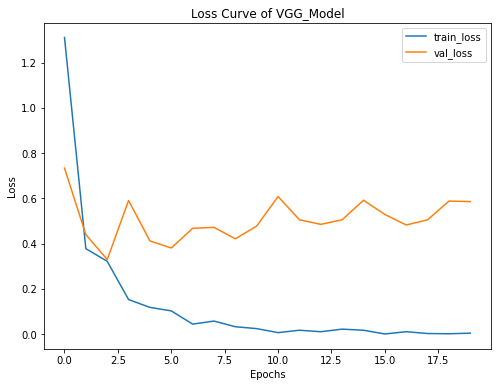

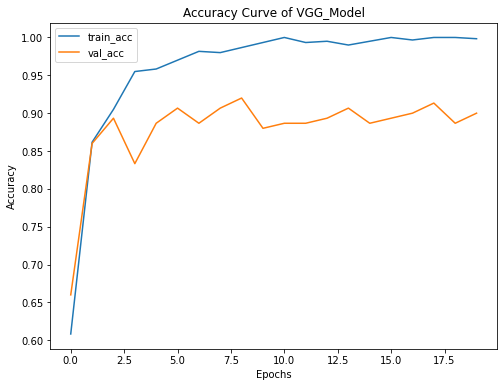

In [10]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve of VGG_Model')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history.history['acc'], label='train_acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve of VGG_Model')
plt.legend()
plt.show()

### ***Check Performance***

In [11]:
# get list of all validation file names
fnames = val_generator.filenames

# get the list of corresponding classes
ground_truth = val_generator.classes

# get the dictionary of classes
label2index = val_generator.class_indices

# obtain the list of classes
idx2label = list(label2index.keys())
print('The list of Classes: {}'.format(idx2label))

The list of Classes: ['pumpkin', 'tomato', 'watermelon']


### ***Check No. of Incorrect Predictions***

In [12]:
predictions = np.argmax(model.predict(val_features_vec), axis=1)
prob = model.predict(val_features_vec)

errors = np.where(predictions != ground_truth)[0]

print('No. of Errors: {}/{}'.format(len(errors), nVal))

No. of Errors: 15/150


Original Label: pumpkin, Prediction: watermelon, Confidence: 0.521


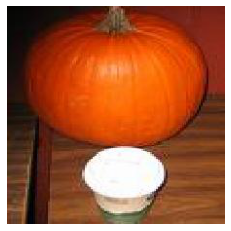

Original Label: pumpkin, Prediction: tomato, Confidence: 0.997


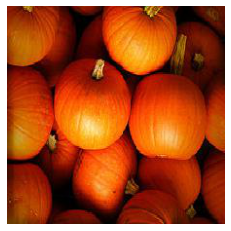

Original Label: pumpkin, Prediction: tomato, Confidence: 0.689


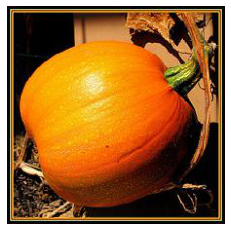

Original Label: pumpkin, Prediction: watermelon, Confidence: 0.662


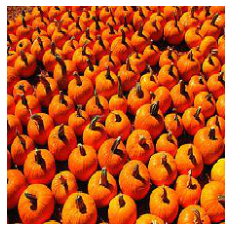

Original Label: pumpkin, Prediction: tomato, Confidence: 0.955


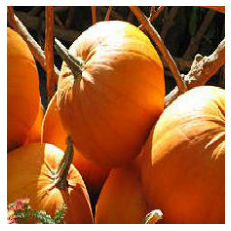

Original Label: pumpkin, Prediction: watermelon, Confidence: 0.872


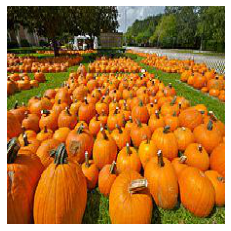

Original Label: pumpkin, Prediction: watermelon, Confidence: 1.000


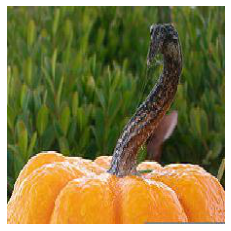

Original Label: pumpkin, Prediction: tomato, Confidence: 0.987


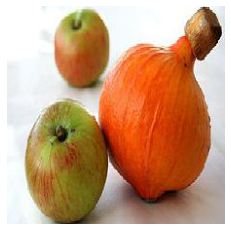

Original Label: tomato, Prediction: pumpkin, Confidence: 0.999


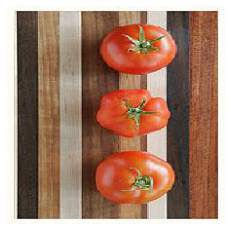

Original Label: tomato, Prediction: pumpkin, Confidence: 0.996


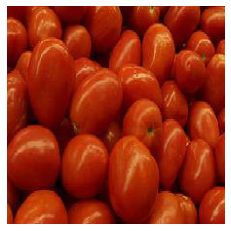

Original Label: tomato, Prediction: pumpkin, Confidence: 0.891


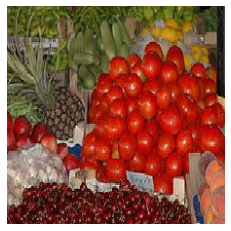

Original Label: tomato, Prediction: watermelon, Confidence: 1.000


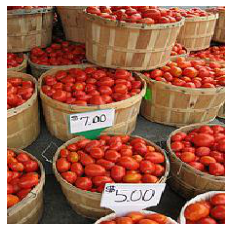

Original Label: tomato, Prediction: pumpkin, Confidence: 0.828


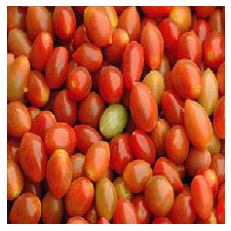

Original Label: watermelon, Prediction: pumpkin, Confidence: 0.997


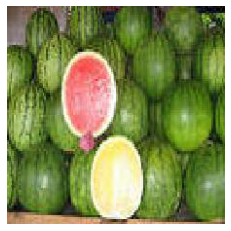

Original Label: watermelon, Prediction: pumpkin, Confidence: 0.804


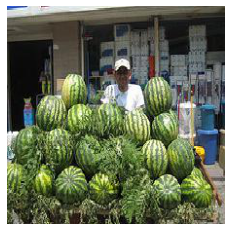

In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

for i in range(len(errors)):
  pred_class = np.argmax(prob[errors[i]])
  pred_label = idx2label[pred_class]
  print('Original Label: {}, Prediction: {}, Confidence: {:.3f}'.format(fnames[errors[i]].split('/')[0],
                                                                        pred_label, 
                                                                        prob[errors[i]][pred_class]))

  original = load_img('{}/{}'.format(validation_dir, fnames[errors[i]]))
  plt.axis('off')
  plt.imshow(original)
  plt.show()

## ***Load PreTrained Model - ResNet50, MobileNet, InceptionV3***

In [15]:
from tensorflow.keras.applications import mobilenet, resnet50, inception_v3

resnet_conv = resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
mobilenet_conv = mobilenet.MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
inception_conv = inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

87916544/87910968 [==============================] - 1s 0us/step


### ***Model Summary - ResNet50 (7,7,2048)***

In [16]:
resnet_conv.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### ***Model Summary - MobileNet (7,7,1024)***

In [17]:
mobilenet_conv.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

### ***Model Summary - InceptionV3 (5,5,2048)***

In [18]:
inception_conv.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### ***Train Feature Generator***

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

# feature space for resnet
train_features_resnet = np.zeros(shape=(nTrain, 7,7,2048))
train_labels_resnet = np.zeros(shape=(nTrain, 3))

# feature space for mobilenet
train_features_mobilenet = np.zeros(shape=(nTrain, 7,7,1024))
train_labels_mobilenet = np.zeros(shape=(nTrain, 3))

# feature space for inception_net
train_features_inception = np.zeros(shape=(nTrain, 5,5,2048))
train_labels_inception = np.zeros(shape=(nTrain, 3))

train_generator = datagen.flow_from_directory(train_dir, 
                                              target_size=(224,224),
                                              batch_size=batch_size, 
                                              class_mode='categorical',
                                              shuffle=True)

# feature generator for resnet 
for i, (input_batch, label_batch) in enumerate(train_generator):
  if i*batch_size >= nTrain:
    break
  
  features_batch = resnet_conv.predict(input_batch)
  train_features_resnet[i*batch_size: (i+1)*batch_size] = features_batch
  train_labels_resnet[i*batch_size: (i+1)*batch_size] = label_batch

train_features_resnet_vec = np.reshape(train_features_resnet, newshape=(nTrain, 7*7*2048))
print('ResNet50 Feature Vec Shape: {}'.format(train_features_resnet_vec.shape))

# feature generator for mobilenet
for i, (input_batch, label_batch) in enumerate(train_generator):
  if i*batch_size >= nTrain:
    break

  features_batch = mobilenet_conv.predict(input_batch)
  train_features_mobilenet[i*batch_size: (i+1)*batch_size] = features_batch
  train_labels_mobilenet[i*batch_size:(i+1)*batch_size] = label_batch

train_features_mobnet_vec = np.reshape(train_features_mobilenet, newshape=(nTrain, 7*7*1024))
print('MobileNet Feature Vec Shape: {}'.format(train_features_mobnet_vec.shape))

# feature generator for inception_net
for i, (input_batch, label_batch) in enumerate(train_generator):
  if i*batch_size >= nTrain:
    break
  
  features_batch = inception_conv.predict(input_batch)
  train_features_inception[i*batch_size: (i+1)*batch_size] = features_batch
  train_labels_inception[i*batch_size: (i+1)*batch_size] = label_batch

train_features_incept_vec = np.reshape(train_features_inception, newshape=(nTrain, 5*5*2048))
print('InceptionV3 Feature Vec Shape: {}'.format(train_features_incept_vec.shape))

Found 600 images belonging to 3 classes.
ResNet50 Feature Vec Shape: (600, 100352)
MobileNet Feature Vec Shape: (600, 50176)
InceptionV3 Feature Vec Shape: (600, 51200)


In [20]:
features_batch.shape

(20, 5, 5, 2048)

### ***Validation Feature Generator***

In [21]:
batch_size = 10

val_generator = datagen.flow_from_directory(validation_dir, 
                                            target_size=(224, 224),
                                            batch_size=batch_size, 
                                            class_mode='categorical',
                                            shuffle=False)



# val_feature space for resnet
val_features_resnet = np.zeros(shape=(nVal,7,7,2048))
val_labels_resnet = np.zeros(shape=(nVal, 3))

for i, (input_batch, label_batch) in enumerate(val_generator):
  if i*batch_size >= nVal:
    break
  
  features_batch = resnet_conv.predict(input_batch)
  val_features_resnet[i*batch_size: (i+1)*batch_size] = features_batch
  val_labels_resnet[i*batch_size: (i+1)*batch_size] = label_batch

val_features_resnet_vec = np.reshape(val_features_resnet, newshape=(nVal, 7*7*2048))
print('Validation_Feature Vec_Resnet Shape: {}'.format(val_features_resnet_vec.shape))

# val_feature space for mobilenet
val_features_mobnet = np.zeros(shape=(nVal, 7,7, 1024))
val_labels_mobnet = np.zeros(shape=(nVal, 3))


for i, (input_batch, label_batch) in enumerate(val_generator):
  if i*batch_size >= nVal:
    break
  
  features_batch = mobilenet_conv.predict(input_batch)
  val_features_mobnet[i*batch_size: (i+1)*batch_size] = features_batch
  val_labels_mobnet[i*batch_size: (i+1)*batch_size] = label_batch

val_features_mobnet_vec = np.reshape(val_features_mobnet, newshape=(nVal, 7*7*1024))
print('Validation_Feature Vec_MobileNet Shape: {}'.format(val_features_mobnet_vec.shape))

# val_feature space for inceptionV3
val_features_inception = np.zeros(shape=(nVal, 5,5, 2048))
val_labels_inception = np.zeros(shape=(nVal, 3))

for i, (input_batch, label_batch) in enumerate(val_generator):
  if i*batch_size >= nVal:
    break
  
  features_batch = inception_conv.predict(input_batch)
  val_features_inception[i*batch_size: (i+1)*batch_size] = features_batch
  val_labels_inception[i*batch_size: (i+1)*batch_size] = label_batch

val_features_inception_vec = np.reshape(val_features_inception, newshape=(nVal, 5*5*2048))
print('Validation_Feature Vec_InceptionV3 Shape: {}'.format(val_features_inception_vec.shape))

Found 150 images belonging to 3 classes.
Validation_Feature Vec_Resnet Shape: (150, 100352)
Validation_Feature Vec_MobileNet Shape: (150, 50176)
Validation_Feature Vec_InceptionV3 Shape: (150, 51200)


### ***Create, Train and Plot Performance***

In [22]:
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, Dropout

# ResNet50 model FC layers 

model_resnet = Sequential()
model_resnet.add(Dense(512, activation='relu', input_dim=(7*7*2048)))
model_resnet.add(Dropout(rate=0.5))
model_resnet.add(Dense(3, activation='softmax'))

model_resnet.compile(optimizer = optimizers.RMSprop(lr=2e-4),
                     loss='categorical_crossentropy',
                     metrics = ['acc'])

# MobileNet model FC layers 

model_mobnet = Sequential()
model_mobnet.add(Dense(512, activation='relu', input_dim=(7*7*1024)))
model_mobnet.add(Dropout(rate=0.5))
model_mobnet.add(Dense(3, activation='softmax'))

model_mobnet.compile(optimizer=optimizers.RMSprop(lr=2e-4),
                     loss='categorical_crossentropy',
                     metrics=['acc'])

# inception_V3 model FC layers 
model_inceptnet = Sequential()
model_inceptnet.add(Dense(512, activation='relu', input_dim=(5*5*2048)))
model_inceptnet.add(Dropout(rate=0.5))
model_inceptnet.add(Dense(3, activation='softmax'))

model_inceptnet.compile(optimizer=optimizers.RMSprop(lr=2e-4),
                        loss='categorical_crossentropy',
                        metrics=['acc'])

In [23]:
def plot_loss_curve(history, title='None'):
  plt.figure(figsize=(8,6))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(title)
  plt.legend()
  plt.show()

  plt.figure(figsize=(8,6))
  plt.plot(history.history['acc'], label='Train Acc')
  plt.plot(history.history['val_acc'], label='Val Acc')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [24]:
# resnet50 model

history_resnet = model_resnet.fit(train_features_resnet_vec, 
                                  train_labels_resnet,
                                  epochs=70, 
                                  batch_size=batch_size,
                                  validation_data=(val_features_resnet_vec, val_labels_resnet))

Epoch 1/70
60/60 [==============================] - 4s 50ms/step - loss: 7.0153 - acc: 0.3391 - val_loss: 1.1992 - val_acc: 0.3333
Epoch 2/70
60/60 [==============================] - 3s 46ms/step - loss: 1.2122 - acc: 0.3376 - val_loss: 1.0835 - val_acc: 0.3533
Epoch 3/70
60/60 [==============================] - 3s 46ms/step - loss: 1.1127 - acc: 0.3672 - val_loss: 1.0871 - val_acc: 0.3667
Epoch 4/70
60/60 [==============================] - 3s 46ms/step - loss: 1.1300 - acc: 0.3476 - val_loss: 1.0721 - val_acc: 0.5800
Epoch 5/70
60/60 [==============================] - 3s 46ms/step - loss: 1.0989 - acc: 0.4242 - val_loss: 1.1635 - val_acc: 0.3333
Epoch 6/70
60/60 [==============================] - 3s 46ms/step - loss: 1.1191 - acc: 0.4060 - val_loss: 1.1075 - val_acc: 0.3333
Epoch 7/70
60/60 [==============================] - 3s 46ms/step - loss: 1.0960 - acc: 0.3578 - val_loss: 1.0603 - val_acc: 0.4733
Epoch 8/70
60/60 [==============================] - 3s 46ms/step - loss: 1.0662 - a

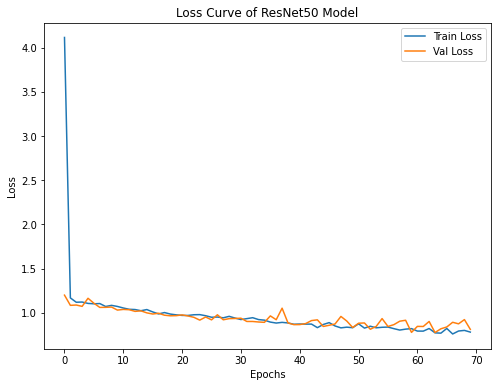

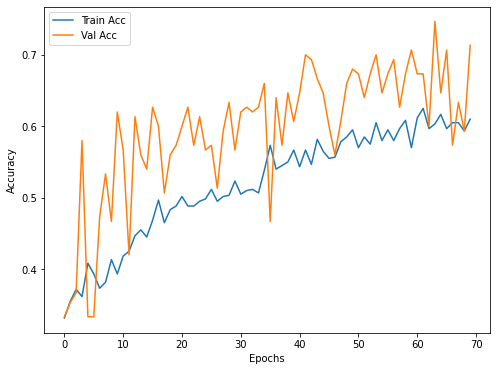

In [25]:
plot_loss_curve(history_resnet, title='Loss Curve of ResNet50 Model')

Epoch 1/20
60/60 [==============================] - 2s 27ms/step - loss: 4.3620 - acc: 0.7584 - val_loss: 0.6348 - val_acc: 0.9067
Epoch 2/20
60/60 [==============================] - 1s 24ms/step - loss: 0.3046 - acc: 0.9597 - val_loss: 0.4076 - val_acc: 0.9600
Epoch 3/20
60/60 [==============================] - 1s 24ms/step - loss: 0.1339 - acc: 0.9865 - val_loss: 0.3813 - val_acc: 0.9600
Epoch 4/20
60/60 [==============================] - 1s 24ms/step - loss: 0.1139 - acc: 0.9803 - val_loss: 0.3071 - val_acc: 0.9667
Epoch 5/20
60/60 [==============================] - 1s 24ms/step - loss: 0.0487 - acc: 0.9936 - val_loss: 0.4877 - val_acc: 0.9533
Epoch 6/20
60/60 [==============================] - 1s 24ms/step - loss: 0.0402 - acc: 0.9951 - val_loss: 0.4736 - val_acc: 0.9467
Epoch 7/20
60/60 [==============================] - 1s 24ms/step - loss: 0.0302 - acc: 0.9973 - val_loss: 0.3044 - val_acc: 0.9600
Epoch 8/20
60/60 [==============================] - 1s 24ms/step - loss: 0.1018 - a

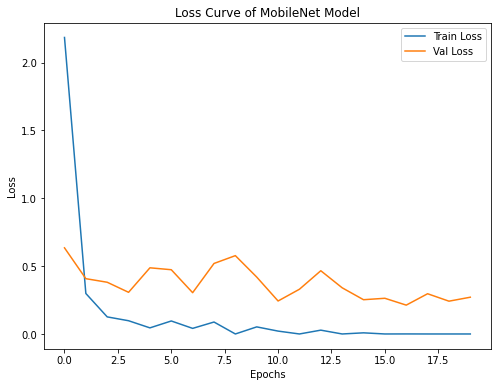

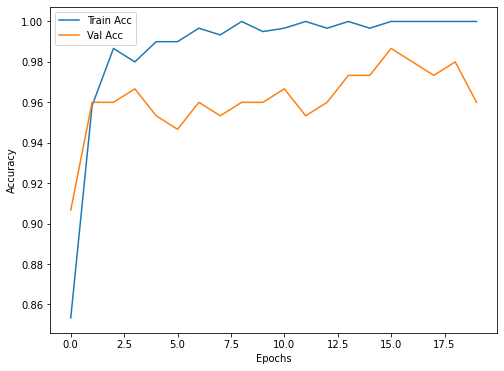

In [26]:
# mobilenet model 

history_mobnet = model_mobnet.fit(train_features_mobnet_vec,
                                  train_labels_mobilenet,
                                  batch_size=batch_size, 
                                  epochs=20,
                                  validation_data=(val_features_mobnet_vec, val_labels_mobnet))

plot_loss_curve(history_mobnet, title='Loss Curve of MobileNet Model')

Epoch 1/20
60/60 [==============================] - 2s 32ms/step - loss: 9.9782 - acc: 0.6316 - val_loss: 0.6401 - val_acc: 0.9467
Epoch 2/20
60/60 [==============================] - 1s 24ms/step - loss: 0.6762 - acc: 0.9297 - val_loss: 0.7112 - val_acc: 0.9400
Epoch 3/20
60/60 [==============================] - 1s 24ms/step - loss: 0.2454 - acc: 0.9657 - val_loss: 0.5458 - val_acc: 0.9333
Epoch 4/20
60/60 [==============================] - 1s 24ms/step - loss: 0.1140 - acc: 0.9798 - val_loss: 0.5575 - val_acc: 0.9467
Epoch 5/20
60/60 [==============================] - 1s 25ms/step - loss: 0.4343 - acc: 0.9582 - val_loss: 0.7190 - val_acc: 0.9333
Epoch 6/20
60/60 [==============================] - 1s 25ms/step - loss: 0.1912 - acc: 0.9672 - val_loss: 0.3945 - val_acc: 0.9733
Epoch 7/20
60/60 [==============================] - 1s 25ms/step - loss: 0.1334 - acc: 0.9880 - val_loss: 0.5648 - val_acc: 0.9533
Epoch 8/20
60/60 [==============================] - 1s 24ms/step - loss: 0.1522 - a

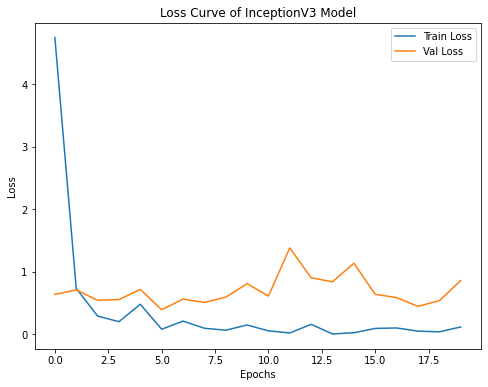

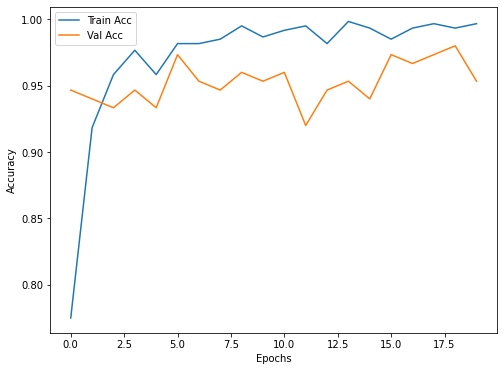

In [27]:
# inception_v3 net model

history_inceptnet = model_inceptnet.fit(train_features_incept_vec,
                                        train_labels_inception,
                                        batch_size=batch_size,
                                        epochs=20, 
                                        validation_data=(val_features_inception_vec, val_labels_inception))

plot_loss_curve(history_inceptnet, title='Loss Curve of InceptionV3 Model')

### ***Check No. of Incorrect Predictions***

In [28]:
# get list of all validation file names
fnames = val_generator.filenames

# get the list of corresponding classes
ground_truth = val_generator.classes

# get the dictionary of classes
label2index = val_generator.class_indices

# obtain the list of classes
idx2label = list(label2index.keys())
print('The list of Classes: {}'.format(idx2label))

The list of Classes: ['pumpkin', 'tomato', 'watermelon']


In [29]:
def model_error(model=None, val_features=None, model_name='None'):
  predictions = np.argmax(model.predict(val_features), axis=1)
  prob = model.predict(val_features)

  errors = np.where(predictions != ground_truth)[0]
  print(model_name + ' Error Rate: {}/{}'.format(len(errors), nVal))

model_error(model_resnet, val_features_resnet_vec, 'ResNet50')
model_error(model_mobnet, val_features_mobnet_vec, 'MobileNet')
model_error(model_inceptnet, val_features_inception_vec, 'InceptionV3')

ResNet50 Error Rate: 43/150
MobileNet Error Rate: 34/150
InceptionV3 Error Rate: 61/150


# ***Fine Tuning for Better Performance and our Use Case***

1. The task of fine-tuning a network is to tweak the parameters of an already trained network so that it adapts to the new task at hand. As explained here, the initial layers learn very general features and as we go higher up the network, the layers tend to learn patterns more specific to the task it is being trained on. Thus, for fine-tuning, we want to keep the initial layers intact ( or freeze them ) and retrain the later layers for our task.

2. Thus, fine-tuning avoids both the limitations discussed above.

3. The amount of data required for training is not much because of two reasons. First, we are not training the entire network. Second, the part that is being trained is not trained from scratch.


4. Since the parameters that need to be updated is less, the amount of time needed will also be less.

## ***Load Pretrained Model_ [VGG16]***

In [30]:
from tensorflow.keras.applications import vgg16

vgg_conv = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

## ***Freeze Required Layers***

In [31]:
# freeze all layers
for layer in vgg_conv.layers[:]:
  layer.trainable = False

# check trainable status of individual layers
for layer in vgg_conv.layers[:]:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb79a9ce9d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb79c8cf7d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb79a94f490> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb79a9904d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb79c78b750> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb7961f4e50> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb79ad5c9d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb79a6e2f90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb79a6e2f10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb79c783350> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb79c6e3350> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

## ***Create New Model (FullyConnected Layers)***

In [32]:
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten

model_vgg_fntune = Sequential()

# add convolutional base model
model_vgg_fntune.add(vgg_conv)

# add new FC layers
model_vgg_fntune.add(Flatten())
model_vgg_fntune.add(Dense(1024, activation='relu'))
model_vgg_fntune.add(Dropout(rate=0.5))
model_vgg_fntune.add(Dense(3, activation='softmax'))


model_vgg_fntune.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 3075      
Total params: 40,408,899
Trainable params: 25,694,211
Non-trainable params: 14,714,688
_________________________________________________________________


## ***Setup Train and Val Data Generators***

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 100
val_batchsize = 10

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    batch_size=train_batchsize,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory(validation_dir,
                                                target_size=(224, 224),
                                                batch_size=val_batchsize,
                                                class_mode='categorical',
                                                shuffle=False)

Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


## ***Train VGG_FNTUNE_MODEL***

In [34]:
model_vgg_fntune.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                         loss = 'categorical_crossentropy',
                         metrics=['acc'])

history_vgg_fntune = model_vgg_fntune.fit(train_generator,
                                          steps_per_epoch= train_generator.samples/train_generator.batch_size,
                                          epochs= 20,
                                          validation_data= val_generator,
                                          validation_steps=val_generator.samples/val_generator.batch_size,
                                          verbose=1)

Epoch 1/20
6/6 [==============================] - 35s 1s/step - loss: 3.7669 - acc: 0.3848 - val_loss: 0.6682 - val_acc: 0.6733
Epoch 2/20
6/6 [==============================] - 7s 1s/step - loss: 0.9361 - acc: 0.6444 - val_loss: 0.4344 - val_acc: 0.8467
Epoch 3/20
6/6 [==============================] - 7s 1s/step - loss: 0.3623 - acc: 0.8724 - val_loss: 1.1045 - val_acc: 0.6667
Epoch 4/20
6/6 [==============================] - 7s 1s/step - loss: 0.7097 - acc: 0.7013 - val_loss: 0.5452 - val_acc: 0.8000
Epoch 5/20
6/6 [==============================] - 7s 1s/step - loss: 0.2703 - acc: 0.8973 - val_loss: 0.3239 - val_acc: 0.9000
Epoch 6/20
6/6 [==============================] - 7s 1s/step - loss: 0.1390 - acc: 0.9597 - val_loss: 0.7800 - val_acc: 0.7000
Epoch 7/20
6/6 [==============================] - 7s 1s/step - loss: 0.4641 - acc: 0.8088 - val_loss: 0.2988 - val_acc: 0.9067
Epoch 8/20
6/6 [==============================] - 7s 1s/step - loss: 0.0586 - acc: 0.9985 - val_loss: 0.3143 -

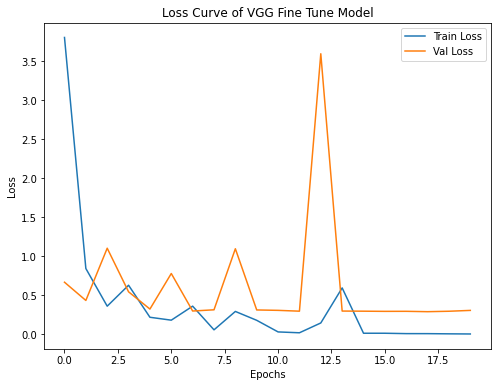

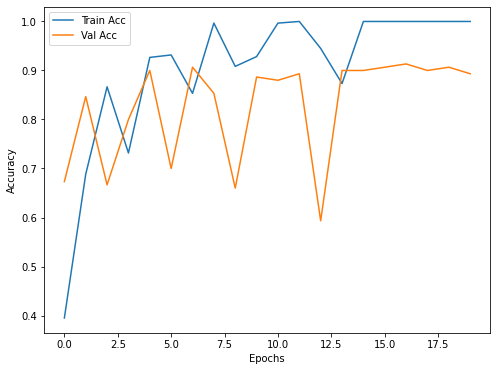

In [35]:
plot_loss_curve(history_vgg_fntune, title='Loss Curve of VGG Fine Tune Model')

## **Define Error and ErrorPlot Functions**

In [67]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.imagenet_utils import decode_predictions

def obtain_errors(val_generator, predictions):
  # get filenames from generator
  fnames = val_generator.filenames

  # get groundtruth from generator
  ground_truth = val_generator.classes

  # get dictionary of classes
  label2index = val_generator.class_indices

  # obtain list of classes 
  idx2label = list(label2index.keys())
  print('The list of classes: {}'.format(idx2label))

  predicted_classes = np.argmax(predictions, axis=1)
  errors = np.where(predicted_classes != ground_truth)[0]
  print('Number of Errors: {}/{}'.format(len(errors), val_generator.samples))

  return idx2label, errors, fnames

def show_errors(idx2label, errors, predictions, fnames, i_range):

  # show errors
  for i in range(i_range):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]

    title = 'Original Label: {}, Prediction: {}, Confidence: {:.3f}'.format(fnames[errors[i]].split('/')[0],
                                                                            pred_label,
                                                                            predictions[errors[i]][pred_class])
    
    original = load_img('{}/{}'.format(validation_dir, fnames[errors[i]]))
    plt.figure(figsize=(7,7))
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

15/15 [==============================] - 2s 130ms/step
The list of classes: ['pumpkin', 'tomato', 'watermelon']
Number of Errors_VGG_FINETUNE: 16/150


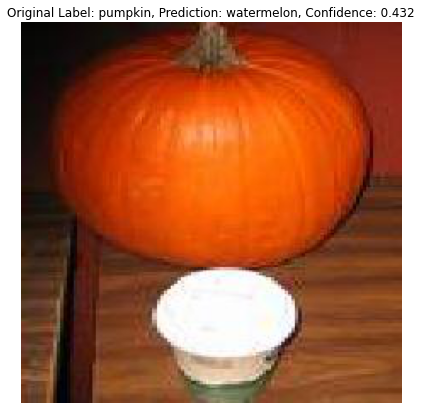

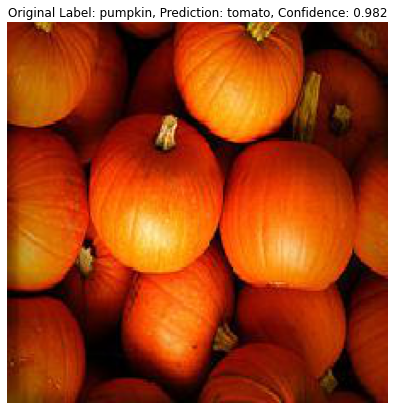

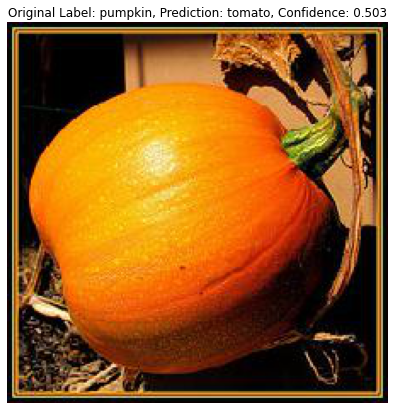

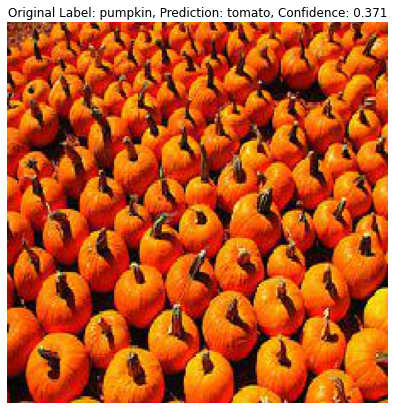

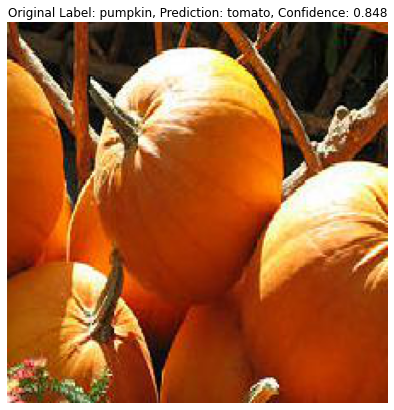

In [37]:
predictions = model_vgg_fntune.predict(val_generator, steps=val_generator.samples/val_generator.batch_size, verbose=1)
idx2label, errors, fnames = obtain_errors(val_generator, predictions)
show_errors(idx2label, errors, predictions, fnames, 5)

# ***Experiment 1 - Train last 4 layers of VGG without Data Augmentation***

In [38]:
from tensorflow.keras.applications import vgg16

vgg_conv = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

### ***Freeze all but Last 4 Layers***

In [39]:
# freeze all but last 4 layers
for layer in vgg_conv.layers[:-4]:
  layer.trainable=False

# check if freezing works
for layer in vgg_conv.layers[:]:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb7926f3410> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb79265c6d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb792667f90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb792670f10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb79288ff10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb7929549d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb792678f90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb792673f10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb792685250> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb79266db90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb7928ff310> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

### ***Create Model and Print Summary***

In [40]:
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten

model_vgg_fntune_last4 = Sequential()
model_vgg_fntune_last4.add(vgg_conv)

model_vgg_fntune_last4.add(Flatten())
model_vgg_fntune_last4.add(Dense(1024, activation='relu'))
model_vgg_fntune_last4.add(Dropout(rate=0.5))
model_vgg_fntune_last4.add(Dense(3, activation='softmax'))

print(model_vgg_fntune_last4.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 3075      
Total params: 40,408,899
Trainable params: 32,773,635
Non-trainable params: 7,635,264
_________________________________________________________________
None


### ***Setup Train and Val Data Generators***

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize=100
val_batchsize=10

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    batch_size=train_batchsize)

val_generator = val_datagen.flow_from_directory(validation_dir, 
                                                target_size=(224,224),
                                                batch_size=val_batchsize,
                                                class_mode = 'categorical',
                                                shuffle=False)

Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


### ***Train Model, Save and Visualize***

Epoch 1/20
6/6 [==============================] - 10s 1s/step - loss: 2.0766 - acc: 0.3905 - val_loss: 1.5300 - val_acc: 0.3333
Epoch 2/20
6/6 [==============================] - 8s 1s/step - loss: 1.1924 - acc: 0.4951 - val_loss: 0.9699 - val_acc: 0.5733
Epoch 3/20
6/6 [==============================] - 8s 1s/step - loss: 0.7533 - acc: 0.6825 - val_loss: 0.6699 - val_acc: 0.7533
Epoch 4/20
6/6 [==============================] - 8s 1s/step - loss: 0.4641 - acc: 0.8079 - val_loss: 0.2652 - val_acc: 0.8800
Epoch 5/20
6/6 [==============================] - 8s 1s/step - loss: 0.4053 - acc: 0.8740 - val_loss: 0.2992 - val_acc: 0.9067
Epoch 6/20
6/6 [==============================] - 8s 1s/step - loss: 0.1496 - acc: 0.9666 - val_loss: 0.2821 - val_acc: 0.9067
Epoch 7/20
6/6 [==============================] - 8s 1s/step - loss: 0.0529 - acc: 0.9897 - val_loss: 0.2196 - val_acc: 0.9333
Epoch 8/20
6/6 [==============================] - 8s 1s/step - loss: 0.0198 - acc: 0.9943 - val_loss: 0.8787 -

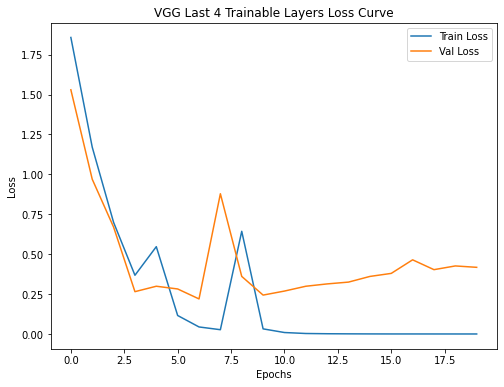

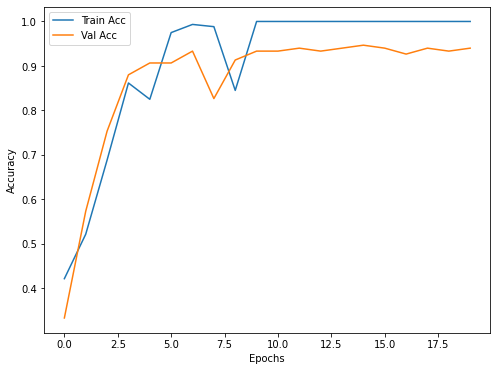

In [42]:
model_vgg_fntune_last4.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                               loss='categorical_crossentropy',
                               metrics=['acc'])

history_vgg_fntune_last4 = model_vgg_fntune_last4.fit(train_generator,
                                                      steps_per_epoch=train_generator.samples/train_generator.batch_size,
                                                      epochs=20,
                                                      validation_data=val_generator,
                                                      validation_steps=val_generator.samples/val_generator.batch_size,
                                                      verbose=1)

model_vgg_fntune_last4.save('last4_layers_vgg.h5')

plot_loss_curve(history_vgg_fntune_last4, title='VGG Last 4 Trainable Layers Loss Curve')

### ***View Errors and Errors Counts***

The list of classes: ['pumpkin', 'tomato', 'watermelon']
Number of Errors_VGG_FINETUNE: 9/150


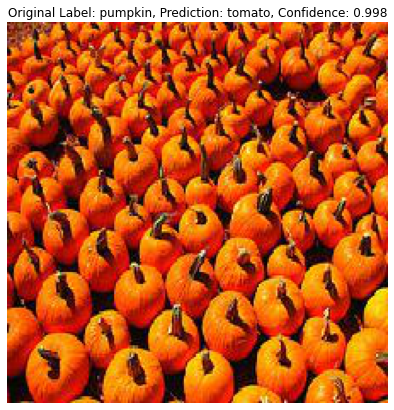

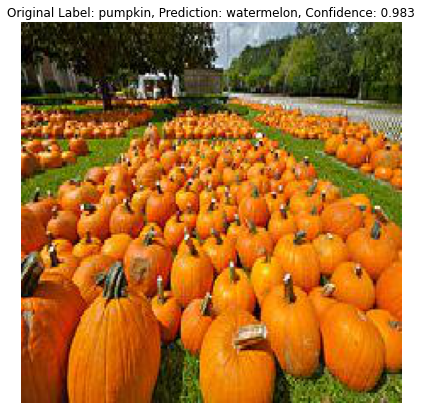

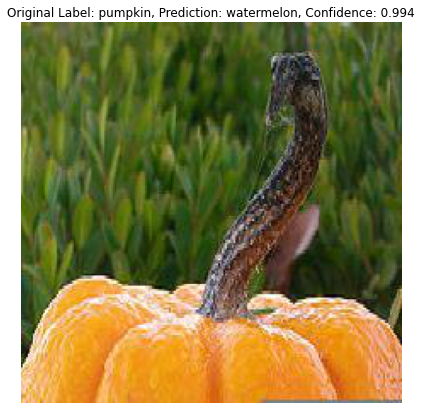

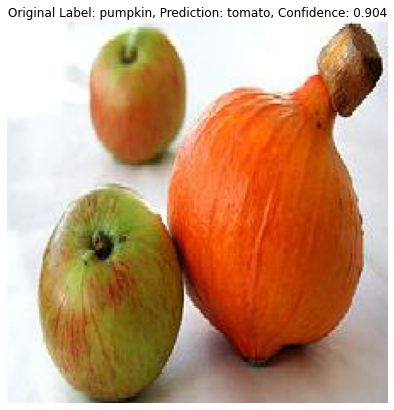

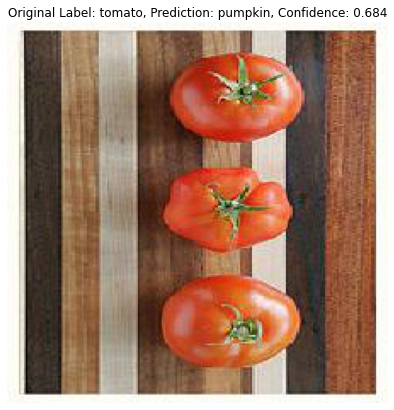

In [43]:
predictions = model_vgg_fntune_last4.predict(val_generator, steps=val_generator.samples/val_generator.batch_size)

idx2label, errors, fnames = obtain_errors(val_generator, predictions)

show_errors(idx2label, errors, predictions, fnames, 5)

# ***Experiment 2 - Train last 4 layers of VGG with Data Augmentation***

### ***Freeze all but Last 4 layers***

In [44]:
from tensorflow.keras.applications import vgg16

vgg_conv = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

for layer in vgg_conv.layers[:-4]:
  layer.trainable = False

for layer in vgg_conv.layers[:]:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb792bbf110> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb792bbf7d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb792bcdd90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb792b53ed0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb792b595d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb792b55d90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb792bcd6d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb792b53d90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb792b59e50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb7926094d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb792b61f90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

### ***Create Model and Print Summary***

In [45]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Sequential, optimizers

model_vgg_fntune_last4_aug = Sequential()
model_vgg_fntune_last4_aug.add(vgg_conv)

model_vgg_fntune_last4_aug.add(Flatten())
model_vgg_fntune_last4_aug.add(Dense(1024, activation='relu'))
model_vgg_fntune_last4_aug.add(Dropout(rate=0.5))
model_vgg_fntune_last4_aug.add(Dense(3, activation='softmax'))

model_vgg_fntune_last4_aug.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 3075      
Total params: 40,408,899
Trainable params: 32,773,635
Non-trainable params: 7,635,264
_________________________________________________________________


### ***Setup Train and Val Data Generators with Data Augmentation***

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 100
val_batchsize = 10

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    class_mode='categorical',
                                                    batch_size=train_batchsize,
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory(validation_dir,
                                                target_size=(224,224),
                                                batch_size=val_batchsize,
                                                class_mode='categorical',
                                                shuffle=False)



Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


### ***Train Model and Visualize***

Epoch 1/40
6/6 [==============================] - 13s 2s/step - loss: 2.5570 - acc: 0.3498 - val_loss: 1.1988 - val_acc: 0.3200
Epoch 2/40
6/6 [==============================] - 11s 2s/step - loss: 1.0811 - acc: 0.4215 - val_loss: 2.2587 - val_acc: 0.3400
Epoch 3/40
6/6 [==============================] - 12s 2s/step - loss: 1.4773 - acc: 0.4936 - val_loss: 0.5241 - val_acc: 0.7933
Epoch 4/40
6/6 [==============================] - 12s 2s/step - loss: 0.8083 - acc: 0.6762 - val_loss: 0.3954 - val_acc: 0.8667
Epoch 5/40
6/6 [==============================] - 12s 2s/step - loss: 0.4341 - acc: 0.8446 - val_loss: 0.3019 - val_acc: 0.9000
Epoch 6/40
6/6 [==============================] - 12s 2s/step - loss: 0.3355 - acc: 0.8852 - val_loss: 0.7903 - val_acc: 0.7200
Epoch 7/40
6/6 [==============================] - 12s 2s/step - loss: 0.3700 - acc: 0.8618 - val_loss: 0.1875 - val_acc: 0.9400
Epoch 8/40
6/6 [==============================] - 12s 2s/step - loss: 0.1564 - acc: 0.9463 - val_loss: 0

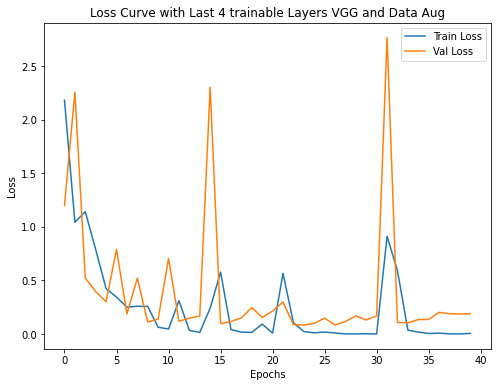

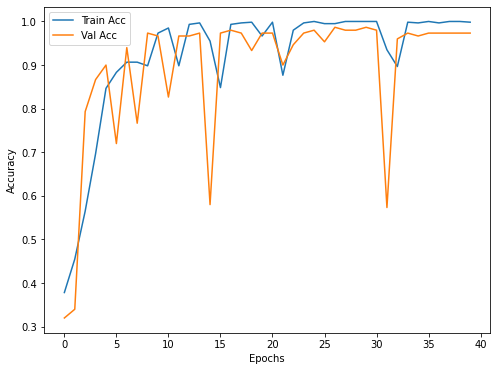

In [47]:
model_vgg_fntune_last4_aug.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                                   loss='categorical_crossentropy',
                                   metrics=['acc'])

history_vgg_fntune_last4_aug = model_vgg_fntune_last4_aug.fit(train_generator,
                                                              steps_per_epoch=train_generator.samples/train_generator.batch_size,
                                                              epochs=40,
                                                              validation_data=val_generator,
                                                              validation_steps=val_generator.samples/val_generator.batch_size,
                                                              verbose=1)

model_vgg_fntune_last4_aug.save('last_4layers_vgg_aug.h5')

plot_loss_curve(history_vgg_fntune_last4_aug, title='Loss Curve with Last 4 trainable Layers VGG and Data Aug')

### ***View Errors and Errors Count***

The list of classes: ['pumpkin', 'tomato', 'watermelon']
Number of Errors_VGG_FINETUNE: 4/150


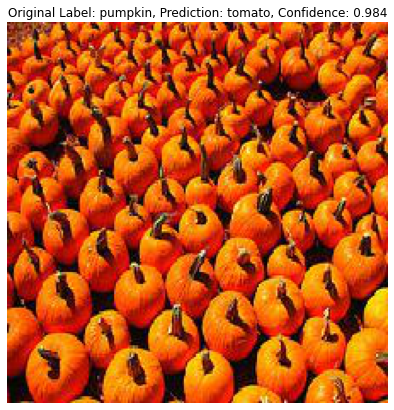

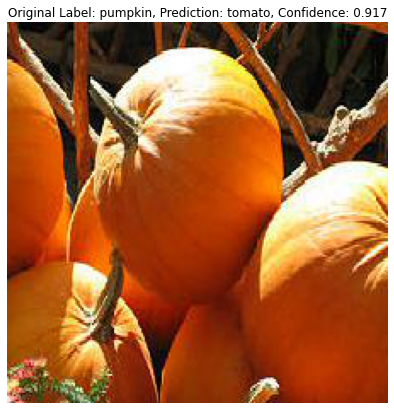

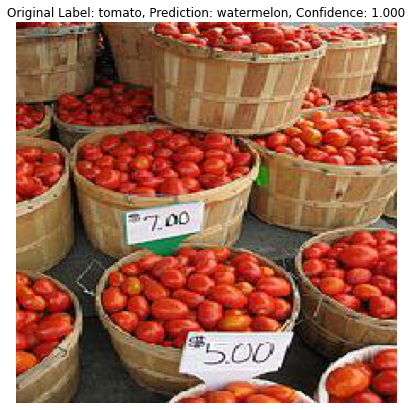

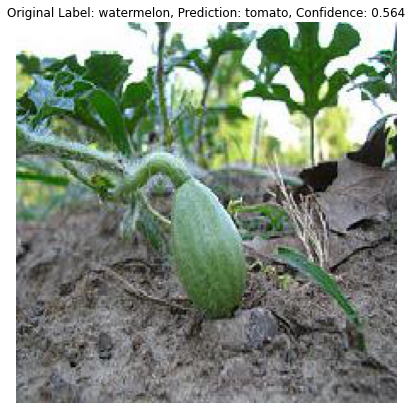

In [48]:
predictions = model_vgg_fntune_last4_aug.predict(val_generator,steps=val_generator.samples/val_generator.batch_size)

idx2label, errors, fnames = obtain_errors(val_generator, predictions)

show_errors(idx2label, errors, predictions, fnames, len(errors))

# ***Experiment 3 - FineTune ResNet50, MobileNet, Inception_V3 | Unfrozen Last 4 Layers and Data Augmentation***

## ***Freeze all but Last 4 layers***

In [49]:
# Unfrozen last 4 layers of ResNet50
for layer in resnet_conv.layers[:-4]:
  layer.trainable=False

for layer in resnet_conv.layers[:]:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb80456c790> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fb80456c7d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb8045fac50> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb88d91a5d0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fb88d9fac50> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fb88d8b86d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb88d8fc2d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb88d8ec490> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb804750590> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fb88d800fd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb88d955510> False
<tensorflow.python.keras.laye

In [56]:
# Unfrozen last 3 layers of MobileNet

for layer in mobilenet_conv.layers[:-3]:
  layer.trainable=False

for layer in mobilenet_conv.layers[:]:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb8044be350> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb804290910> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb8044bebd0> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fb8044a8290> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7fb8044b1f50> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb8044a82d0> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fb804463b10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb804463710> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb8044cdf10> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fb8044d89d0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fb8044

In [57]:
# Freezing all Layers of Inception_V3

for layer in inception_conv.layers[:]:
  layer.trainable = False

for layer in inception_conv.layers[:]:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb804281210> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb80432c2d0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb8043d6c50> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fb8043a65d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb8043ddc50> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb8043d97d0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fb80435a090> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb804326590> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb804356f10> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fb804340510> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb804340590> False
<tensorflow.python.keras.layers.c

## ***Create Model and Print Summary***

In [58]:
# create resnet model

def create_model(conv_net):
  model = Sequential()
  model.add(conv_net)
  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(3, activation='softmax'))

  return model


resnet_last4_fntune_aug = create_model(resnet_conv)

print(resnet_last4_fntune_aug.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              102761472 
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 3075      
Total params: 126,352,259
Trainable params: 103,819,267
Non-trainable params: 22,532,992
_________________________________________________________________
None


In [59]:
# create mobilenet model

mobnet_last3_fntune_aug = create_model(mobilenet_conv)

print(mobnet_last3_fntune_aug.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_4 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              51381248  
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 3075      
Total params: 54,613,187
Trainable params: 52,434,947
Non-trainable params: 2,178,240
_________________________________________________________________
None


In [60]:
# create inception net model

inceptnet_fntune_aug = create_model(inception_conv)

print(inceptnet_fntune_aug.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_5 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              52429824  
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 3075      
Total params: 74,235,683
Trainable params: 52,432,899
Non-trainable params: 21,802,784
_________________________________________________________________
None


## ***Train Model and Visualize***

In [62]:
def model_compile_fit(model, epoch, name):
  model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['acc'])
  
  history = model.fit(train_generator,
                      steps_per_epoch= train_generator.samples/train_generator.batch_size,
                      epochs=epoch,
                      validation_data= val_generator,
                      validation_steps= val_generator.samples/val_generator.batch_size,
                      verbose=1)
  
  model.save(name)

  return history

### ***ResNet50 Model w/ Data Aug and Last 4 Layers***

Epoch 1/100
6/6 [==============================] - 16s 2s/step - loss: 1.2534 - acc: 0.5277 - val_loss: 1.0215 - val_acc: 0.3933
Epoch 2/100
6/6 [==============================] - 11s 2s/step - loss: 1.3134 - acc: 0.4509 - val_loss: 1.0811 - val_acc: 0.4133
Epoch 3/100
6/6 [==============================] - 11s 2s/step - loss: 1.1507 - acc: 0.4956 - val_loss: 0.9717 - val_acc: 0.5333
Epoch 4/100
6/6 [==============================] - 11s 2s/step - loss: 1.0700 - acc: 0.5003 - val_loss: 1.0190 - val_acc: 0.4000
Epoch 5/100
6/6 [==============================] - 11s 2s/step - loss: 0.9261 - acc: 0.5485 - val_loss: 0.9986 - val_acc: 0.4133
Epoch 6/100
6/6 [==============================] - 11s 2s/step - loss: 0.8957 - acc: 0.5811 - val_loss: 1.0743 - val_acc: 0.4800
Epoch 7/100
6/6 [==============================] - 11s 2s/step - loss: 0.9916 - acc: 0.5227 - val_loss: 1.0506 - val_acc: 0.3533
Epoch 8/100
6/6 [==============================] - 11s 2s/step - loss: 0.9122 - acc: 0.5821 - val

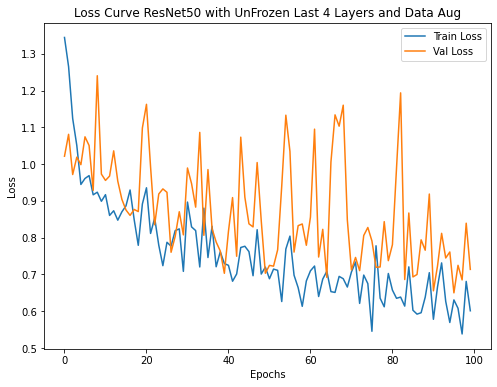

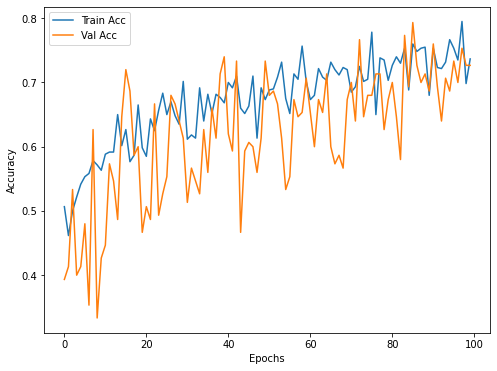

In [64]:
history_resnet_last4_aug = model_compile_fit(resnet_last4_fntune_aug, 100, 'resnet_4_aug.h5')

plot_loss_curve(history_resnet_last4_aug, title='Loss Curve ResNet50 with UnFrozen Last 4 Layers and Data Aug')

In [68]:
predictions = resnet_last4_fntune_aug.predict(val_generator,steps=val_generator.samples/val_generator.batch_size)
idx2label, errors, fnames = obtain_errors(val_generator, predictions)

# show_errors(idx2label, errors, predictions, fnames, 5)

The list of classes: ['pumpkin', 'tomato', 'watermelon']
Number of Errors: 41/150


### ***MobileNet Model w/ Data Aug and Last 3 Layers***

Epoch 1/40
6/6 [==============================] - 11s 1s/step - loss: 14.3231 - acc: 0.4410 - val_loss: 1.0232 - val_acc: 0.8067
Epoch 2/40
6/6 [==============================] - 8s 1s/step - loss: 0.5912 - acc: 0.8681 - val_loss: 1.4279 - val_acc: 0.7733
Epoch 3/40
6/6 [==============================] - 8s 1s/step - loss: 0.1949 - acc: 0.9464 - val_loss: 0.7002 - val_acc: 0.8467
Epoch 4/40
6/6 [==============================] - 8s 1s/step - loss: 0.1969 - acc: 0.9580 - val_loss: 0.3770 - val_acc: 0.9067
Epoch 5/40
6/6 [==============================] - 8s 1s/step - loss: 0.1043 - acc: 0.9604 - val_loss: 0.4658 - val_acc: 0.9067
Epoch 6/40
6/6 [==============================] - 8s 1s/step - loss: 0.1985 - acc: 0.9603 - val_loss: 2.8038 - val_acc: 0.7067
Epoch 7/40
6/6 [==============================] - 8s 1s/step - loss: 1.4259 - acc: 0.8512 - val_loss: 0.5346 - val_acc: 0.9067
Epoch 8/40
6/6 [==============================] - 8s 1s/step - loss: 0.0479 - acc: 0.9839 - val_loss: 0.5790 

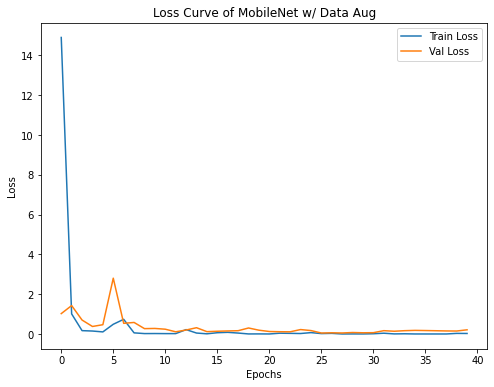

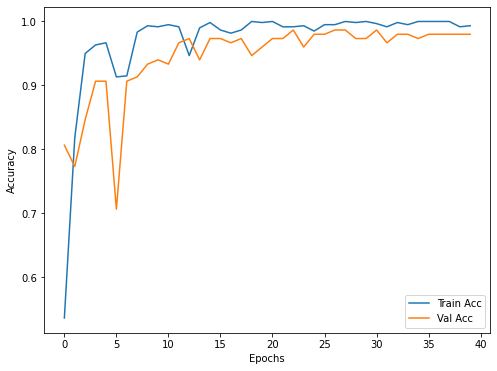

The list of classes: ['pumpkin', 'tomato', 'watermelon']
Number of Errors: 3/150


In [69]:
history_mobnet_last3_aug = model_compile_fit(mobnet_last3_fntune_aug, 40, 'mobnet_3_aug.h5')

plot_loss_curve(history_mobnet_last3_aug, title='Loss Curve of MobileNet w/ Data Aug')

predictions = mobnet_last3_fntune_aug.predict(val_generator, steps=val_generator.samples/val_generator.batch_size)
idx2label, errors, fnames = obtain_errors(val_generator, predictions)

### ***Inception_V3 Model w/ Data Aug***

Epoch 1/40
6/6 [==============================] - 19s 2s/step - loss: 12.5344 - acc: 0.4800 - val_loss: 5.1829 - val_acc: 0.5533
Epoch 2/40
6/6 [==============================] - 10s 2s/step - loss: 4.1597 - acc: 0.6990 - val_loss: 0.1915 - val_acc: 0.9467
Epoch 3/40
6/6 [==============================] - 10s 2s/step - loss: 0.3768 - acc: 0.9259 - val_loss: 0.1828 - val_acc: 0.9467
Epoch 4/40
6/6 [==============================] - 10s 2s/step - loss: 0.3655 - acc: 0.9397 - val_loss: 0.4714 - val_acc: 0.9133
Epoch 5/40
6/6 [==============================] - 10s 2s/step - loss: 0.6631 - acc: 0.9047 - val_loss: 0.2112 - val_acc: 0.9600
Epoch 6/40
6/6 [==============================] - 10s 2s/step - loss: 0.3833 - acc: 0.9301 - val_loss: 1.2029 - val_acc: 0.7600
Epoch 7/40
6/6 [==============================] - 10s 2s/step - loss: 4.0887 - acc: 0.6865 - val_loss: 0.1179 - val_acc: 0.9600
Epoch 8/40
6/6 [==============================] - 10s 2s/step - loss: 0.1799 - acc: 0.9606 - val_loss: 

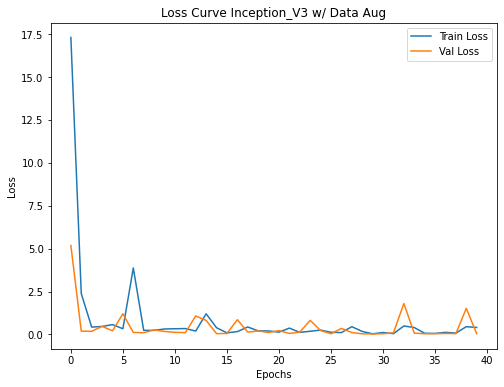

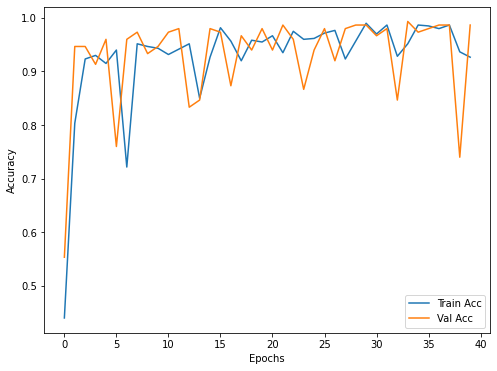

The list of classes: ['pumpkin', 'tomato', 'watermelon']
Number of Errors: 2/150


In [70]:
history_incept_aug = model_compile_fit(inceptnet_fntune_aug, 40, 'inceptnet_aug.h5')

plot_loss_curve(history_incept_aug, title='Loss Curve Inception_V3 w/ Data Aug')

predictions = inceptnet_fntune_aug.predict(val_generator, steps=val_generator.samples/val_generator.batch_size)
idx2label, errors, fnames = obtain_errors(val_generator, predictions)